## Importation des librairies

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import stanza
import jupyter_black
from datasets import Dataset

jupyter_black.load()
# Loading Stanza models for Arabic
stanza.download('ar')

2024-05-09 19:37:00 INFO: Downloaded file to /Users/perrine/stanza_resources/resources.json
INFO:stanza:Downloaded file to /Users/perrine/stanza_resources/resources.json
2024-05-09 19:37:00 INFO: Downloading default packages for language: ar (Arabic) ...
INFO:stanza:Downloading default packages for language: ar (Arabic) ...
2024-05-09 19:37:01 INFO: File exists: /Users/perrine/stanza_resources/ar/default.zip
INFO:stanza:File exists: /Users/perrine/stanza_resources/ar/default.zip
2024-05-09 19:37:03 INFO: Finished downloading models and saved to /Users/perrine/stanza_resources
INFO:stanza:Finished downloading models and saved to /Users/perrine/stanza_resources


## Chargement des données

In [2]:
data = pd.read_csv("../../data/csv/data.csv")

# Création d'un dataset à partir d'un DataFrame
dataset = Dataset.from_pandas(data)
dataset

Dataset({
    features: ['Label', 'Text'],
    num_rows: 4948
})

## Tokenization

In [3]:
# Tokenizers
# Chargement des modèles Spacy
nlp_en = spacy.load("en_core_web_sm")  # English
nlp_es = spacy.load("es_core_news_sm")  # Spanish
nlp_de = spacy.load("de_core_news_sm")  # German
nlp_fr = spacy.load("fr_core_news_sm")  # French
nlp_ru = spacy.load("ru_core_news_sm")  # Russian
nlp_zh = spacy.load("zh_core_web_sm")  # Chinese
nlp_ja = spacy.load("ja_core_news_sm")  # Japanese
nlp_ko = spacy.load("ko_core_news_sm")  # Korean

# Chargement du modèle Stanza
nlp_ar = stanza.Pipeline(lang="ar")

def tokenize_and_annotate(text: str, lang: str) -> list:
    """
    Tokenize et annote morpho-syntaxiquement un texte dans une langue donnée.

    Parameters:
    text (str): le texte à tokeniser et annoter.
    lang (str): la langue du texte.

    Returns:
    list: une liste de tuples (token, POS) pour chaque token du texte.
    """
    if lang == "ar":
        doc = nlp_ar(text)
        return [(word.text, word.upos) for sent in doc.sentences for word in sent.words]
    else:
        nlp = globals()[f"nlp_{lang}"]
        doc = nlp(text)
        return [(token.text, token.pos_) for token in doc]

2024-05-09 19:37:11 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-05-09 19:37:11 INFO: Downloaded file to /Users/perrine/stanza_resources/resources.json
INFO:stanza:Downloaded file to /Users/perrine/stanza_resources/resources.json
2024-05-09 19:37:13 INFO: Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |
| depparse  | padt_charlm   |
| ner       | aqmar_charlm  |

INFO:stanza:Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |
| depparse  | padt_charlm   |
| ner       | aqmar_charlm  |

2024-05-09 19:37:13 INFO: Using device: cpu
INFO:stanza:Using device: cpu
2024-05-09 19:37:13 INFO: Loading: tokenize
INFO:stanza:Loading: tokenize
2024-05-09 19:37:13 INFO: Loading: mwt
INFO:stanza:Loading: mwt
20

## Analyse Morphosyntaxique

In [4]:
# Number of each entity type per language
def count_entities(dataset: list) -> dict:
    """
    Compte le nombre d'entités de chaque type par langue dans un dataset.

    Parameters:
        dataset (list): Le dataset à analyser.

    Returns:
        dict: un dictionnaire dont les clés sont les types d'entités et les valeurs sont des dictionnaires
            dont les clés sont les langues et les valeurs sont les nombres d'entités de ce type dans cette langue.
    """
    entities = {}
    for sentence in dataset:
        text, lang = sentence["Text"], sentence["Label"]
        sentence["tokens_pos"] = tokenize_and_annotate(text, lang)
        for token, pos_tag in sentence["tokens_pos"]:
            if pos_tag not in entities:
                entities[pos_tag] = {}
            if lang not in entities[pos_tag]:
                entities[pos_tag][lang] = 0
            entities[pos_tag][lang] += 1

    sorted_entities = {
        pos_tag: dict(
            sorted(lang_counts.items(), key=lambda item: item[1], reverse=True)
        )
        for pos_tag, lang_counts in sorted(entities.items(), key=lambda x: x[0])
    }

    return sorted_entities


def save_entities_to_csv(entities: dict, file_path="../../resultats/entities.csv"):
    """
    Sauvegarde les entités dans un fichier CSV.

    Parameters:
    entities (dict): un dictionnaire contenant les entités.
    file_path (str): le chemin du fichier de sortie.
    """
    df = pd.DataFrame.from_dict(entities, orient="index")
    df.to_csv(file_path)

1. `count_entities(dataset: list) -> dict`

    Cette fonction prend une liste d'objets, chacun représentant une phrase, et compte combien d'entités de chaque type sont présentes dans chaque langue.

    * ***Initialisation**:
        - `entities` : un dictionnaire vide qui stockera le nombre d'entités pour chaque type et chaque langue.

    * **Boucle sur chaque phrase**:
        - La fonction parcourt chaque phrase du `dataset`.
        - `text` et `lang` sont extraits de chaque phrase, respectivement le texte de la phrase et le code de la langue.

    * **Annotation des tokens**:
        - `sentence['tokens_pos'] = tokenize_and_annotate(text, lang)`: une fonction externe est utilisée pour diviser le texte en tokens et les annoter avec leurs types d'entités.
        - La fonction `tokenize_and_annotate()` renvoie une liste de tuples `(token, pos)`, où `token` est un mot et `pos` est le type d'entité associé.

    * **Mise à jour du comptage**:
        - La fonction parcourt les tokens annotés et met à jour le dictionnaire `entities` pour tenir compte de chaque type d'entité (`pos`) trouvé dans la langue (`lang`).
        - Si `pos` ou `lang` n'existent pas encore dans `entities`, ils sont initialisés.

    * **Tri des résultats**:
        - La fonction trie d'abord les types d'entités (`pos`) par ordre alphabétique, puis trie les langues pour chaque type d'entité par le nombre d'occurrences dans un ordre décroissant.

    * **Retourne les résultats**:
        - La fonction retourne le dictionnaire `sorted_entities`, qui contient le comptage des entités par type et par langue.

2. `save_entites_csv(entities: dict)`

    Cette fonction prend un dictionnaire d'entités et les sauvegarde dans un fichier CSV.

    * **Conversion en DataFrame**:
        - `df` : le dictionnaire `entities` est converti en DataFrame pandas. Cela facilite la sauvegarde sous forme de fichier CSV.

    * **Sauvegarde en CSV**:
        - `df.to_csv("../../resultats/entities.csv")`: la DataFrame est sauvegardée dans un fichier CSV à l'emplacement spécifié.


In [5]:
entities = count_entities(dataset)
entities_csv = save_entities_to_csv(entities)

entities

{'ADJ': {'ar': 6478,
  'ru': 2025,
  'es': 1909,
  'en': 1843,
  'fr': 1768,
  'de': 864,
  'zh': 599,
  'ja': 413,
  'ko': 384},
 'ADP': {'ar': 9696,
  'ja': 6914,
  'fr': 4648,
  'es': 4637,
  'en': 3455,
  'ru': 2101,
  'de': 1911,
  'zh': 842,
  'ko': 270},
 'ADV': {'ko': 1617,
  'zh': 1586,
  'fr': 952,
  'de': 918,
  'en': 771,
  'es': 735,
  'ru': 552,
  'ja': 249,
  'ar': 212},
 'AUX': {'ja': 3129,
  'en': 941,
  'fr': 816,
  'es': 727,
  'de': 583,
  'ar': 453,
  'ko': 281,
  'ru': 195},
 'CCONJ': {'ar': 4660,
  'en': 863,
  'es': 836,
  'ko': 823,
  'fr': 711,
  'ru': 549,
  'de': 462,
  'zh': 390,
  'ja': 144},
 'DET': {'fr': 3564,
  'es': 3462,
  'en': 2529,
  'de': 2017,
  'ar': 1227,
  'ru': 288,
  'zh': 218,
  'ja': 144,
  'ko': 102},
 'INTJ': {'en': 4, 'es': 4, 'ru': 3, 'ar': 2, 'ko': 2, 'zh': 1},
 'NOUN': {'ar': 18683,
  'ja': 11505,
  'zh': 7280,
  'fr': 5788,
  'ko': 5610,
  'en': 5316,
  'ru': 5286,
  'es': 4926,
  'de': 3458},
 'NUM': {'zh': 1025,
  'ar': 374,
  'e

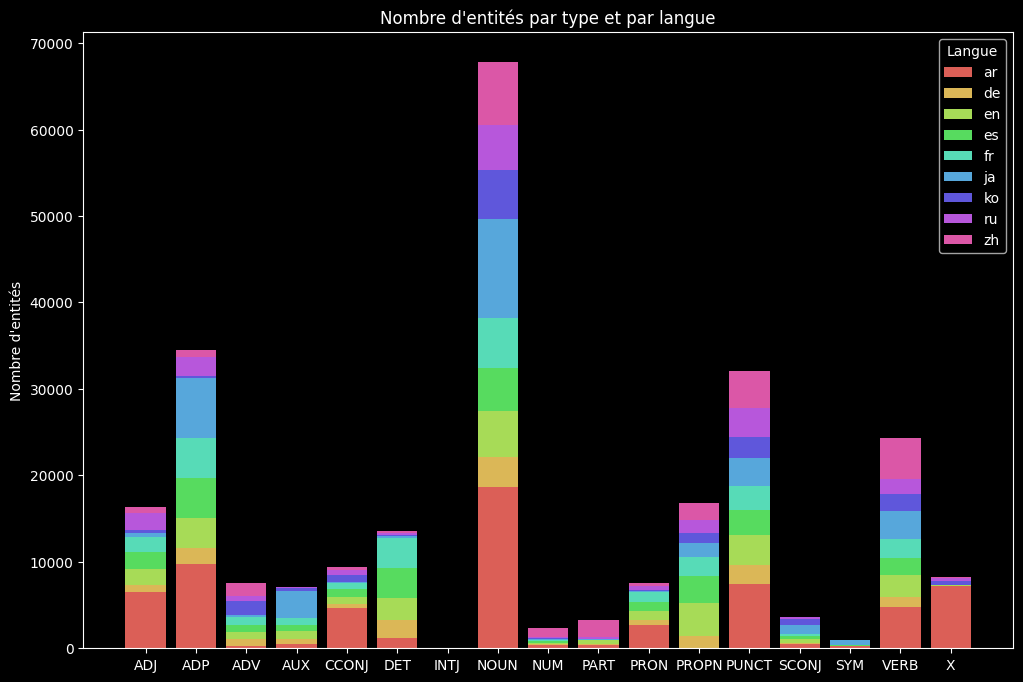

In [6]:
def plot_entity_distribution(data: dict) -> plt.Figure:
    """
    Trace un graphique en barres empilées des entités par langue pour chaque type d'entité.

    Paramètres :
    data (dict): Dictionnaire des entités triées retourné par la fonction count_entities.

    Renvoie :
    plt.Figure: le graphique tracé.
    """
    # Préparation des données pour le tracé
    languages = set()
    for entities in data.values():
        languages.update(entities.keys())
    languages = sorted(languages)

    # Création de données pour le tracé
    labels = list(data.keys())
    bottom = [0] * len(labels)

    # Utilisation de Seaborn pour obtenir une palette de couleurs HLS
    colors = sns.color_palette("hls", len(languages))

    fig, ax = plt.subplots(figsize=(12, 8))

    for idx, lang in enumerate(languages):
        counts = [data[label].get(lang, 0) for label in labels]
        ax.bar(labels, counts, bottom=bottom, color=colors[idx], label=lang)
        bottom = [i + j for i, j in zip(bottom, counts)]

    ax.set_ylabel("Nombre d'entités")
    ax.set_title("Nombre d'entités par type et par langue")
    ax.legend(title="Langue")

    return fig


distribution = plot_entity_distribution(entities)

# Sauvegarde du graphique
distribution.savefig(
    "../../resultats/entity_distribution.png", facecolor="w", bbox_inches="tight"
)

1. **Répartition par Langue** :
   - **Anglais, français et russe** : L'anglais présente une répartition assez homogène à travers différentes catégories, tout comme le français. En revanche, le russe a des contributions notables dans les catégories de l'adjectif (ADJ), de la ponctuation (PUNCT) et du nom propre (PROPN), mais moins dans d'autres catégories telles que l'auxiliaire (AUX) ou l'adverbe (ADV).
   - **Japonais et chinois** : Le japonais montre effectivement une concentration élevée en adpositions (ADP), auxiliaires (AUX) et noms (NOUN), reflétant les caractéristiques linguistiques de la langue qui utilisent abondamment ces types d'entités. Le chinois montre une prédominance en noms (NOUN) et en verbes (VERB).

2. **Types d'Entités** :
   - **Noms (NOUN)** : L'arabe est en fait la langue la plus représentée avec 13 214 occurrences, suivie du japonais et du chinois. Cette catégorie est cruciale pour les langues sémitiques comme l'arabe en raison de leur structure syntaxique riche en noms et substantifs.
   - **Adpositions (ADP)** : Comme attendu, le japonais est dominant avec 6 201 occurrences, ce qui reflète l'utilisation intensive de particules liant les phrases dans la grammaire japonaise.


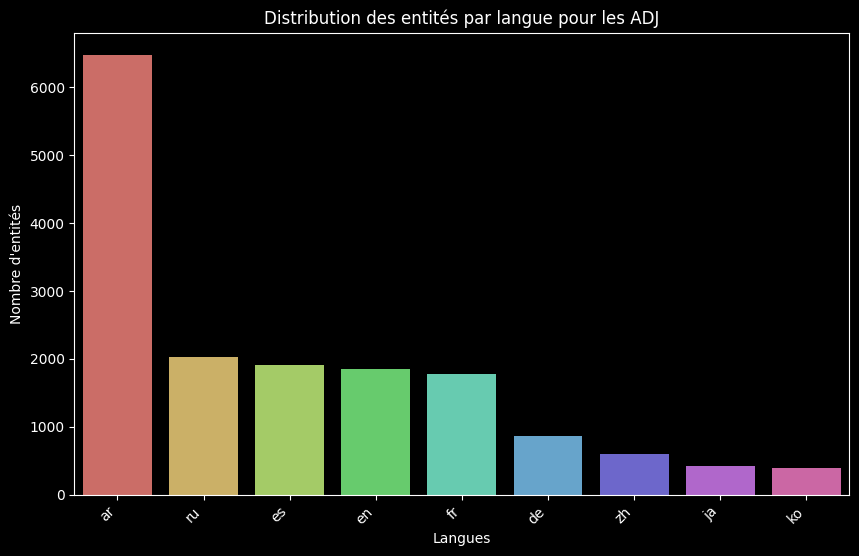

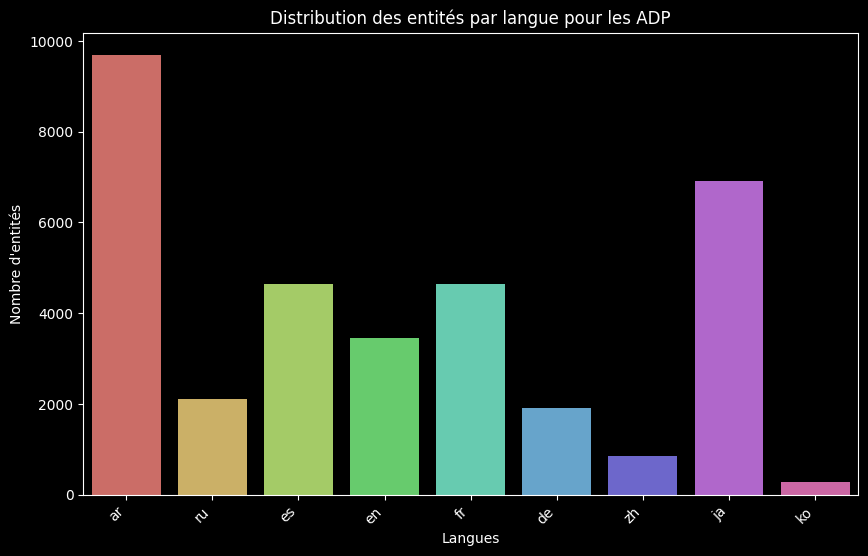

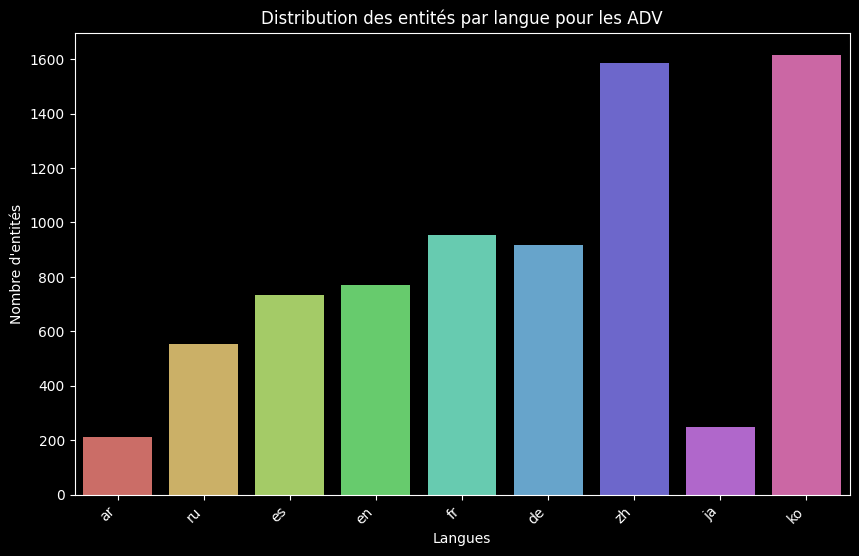

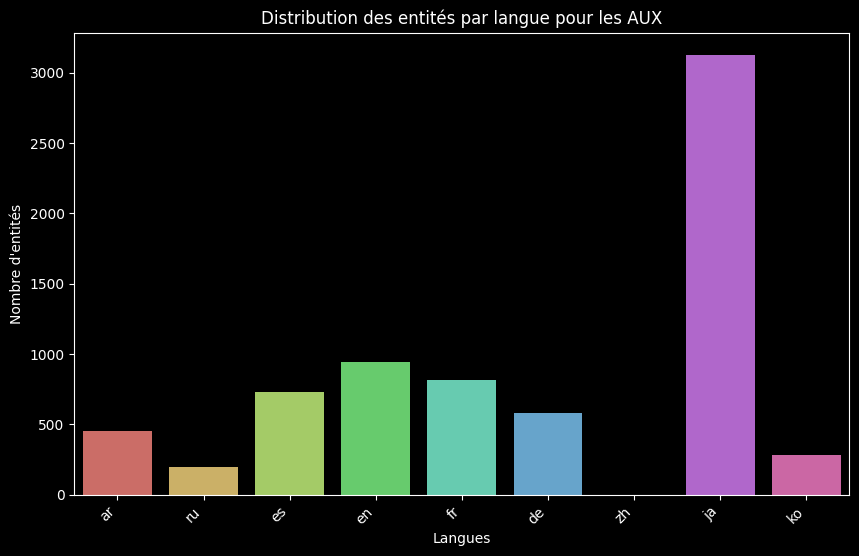

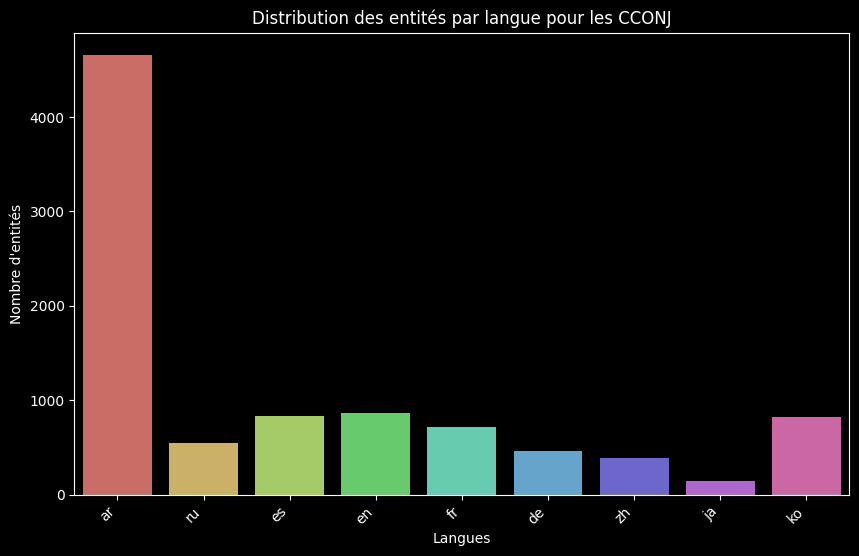

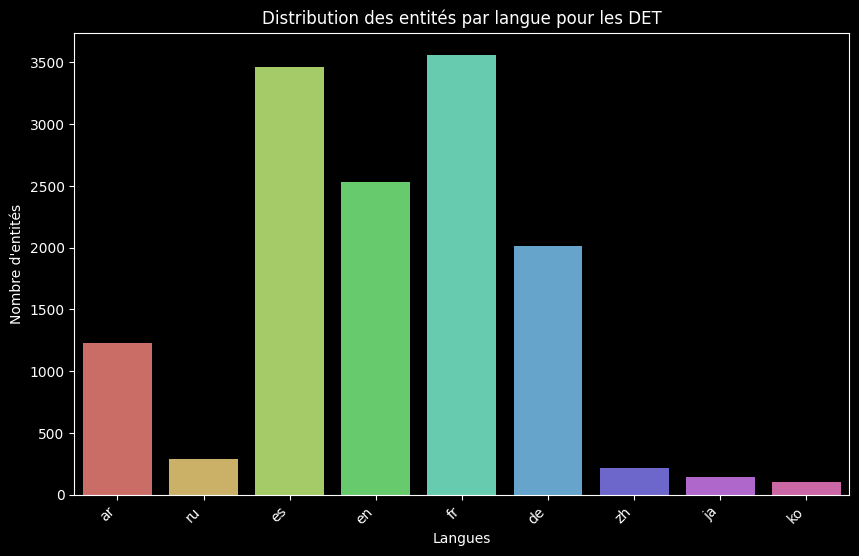

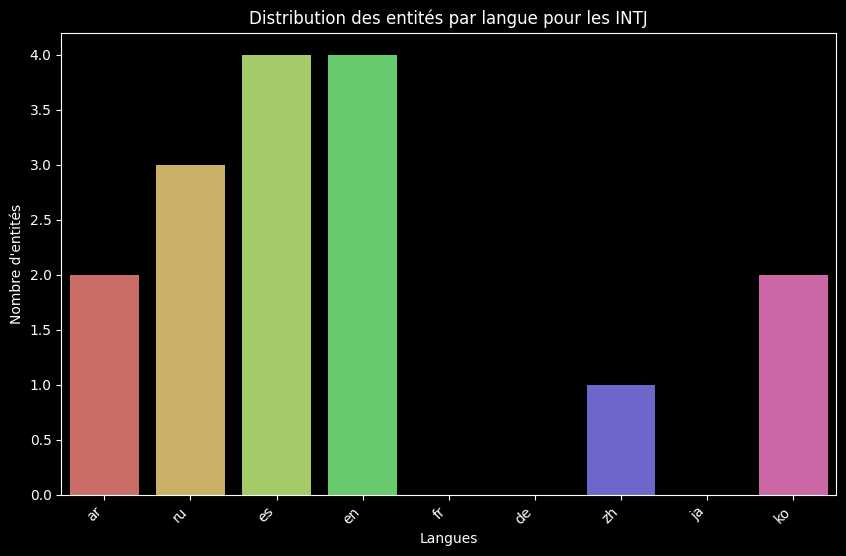

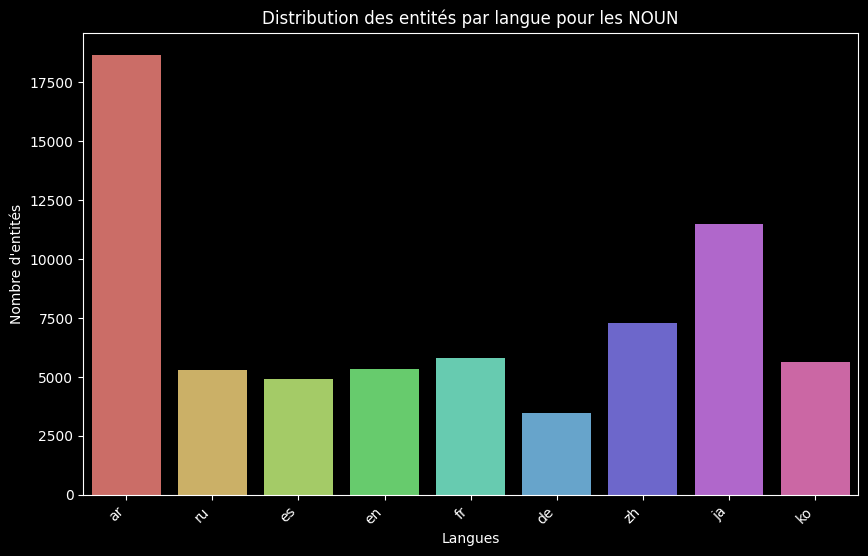

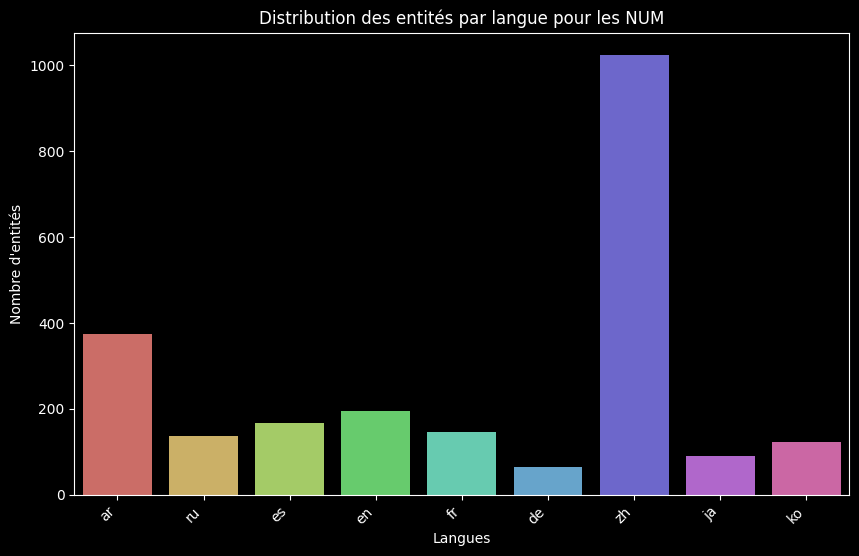

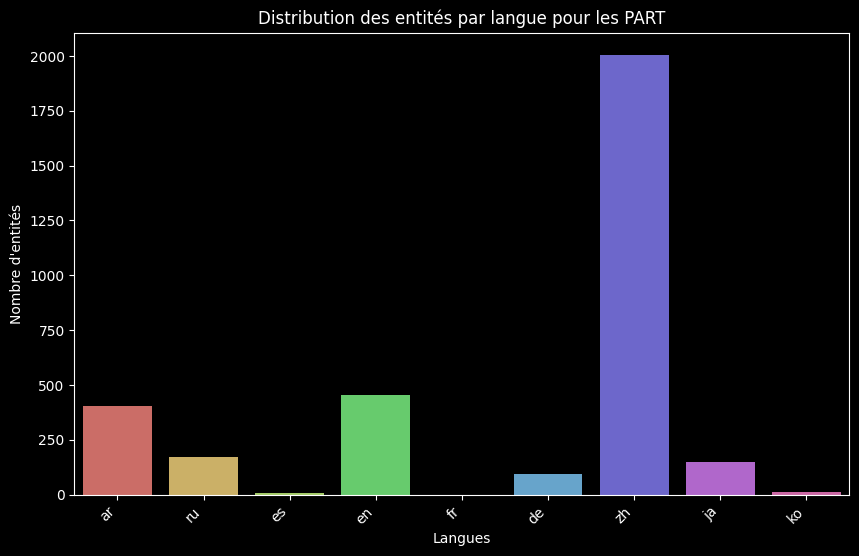

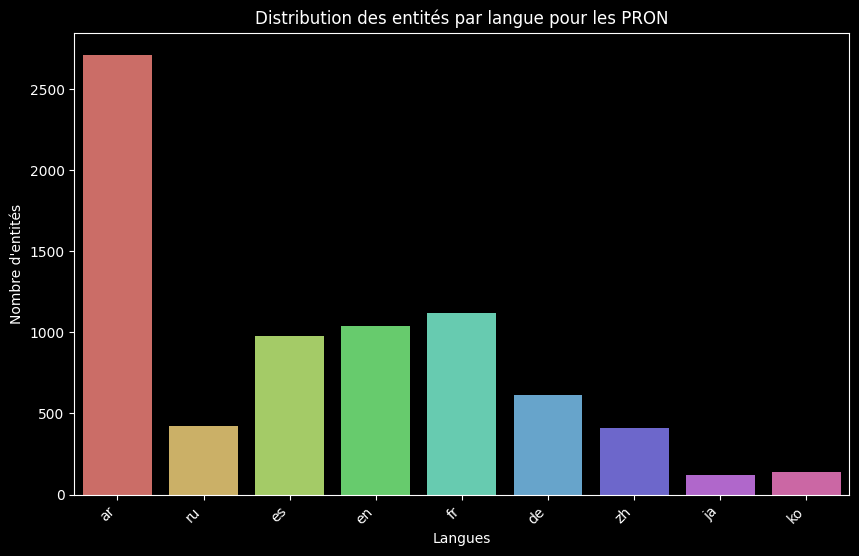

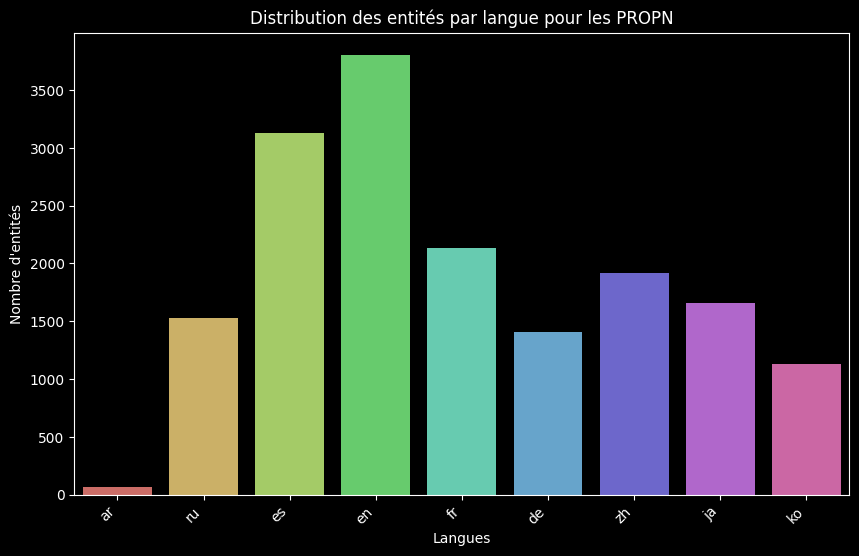

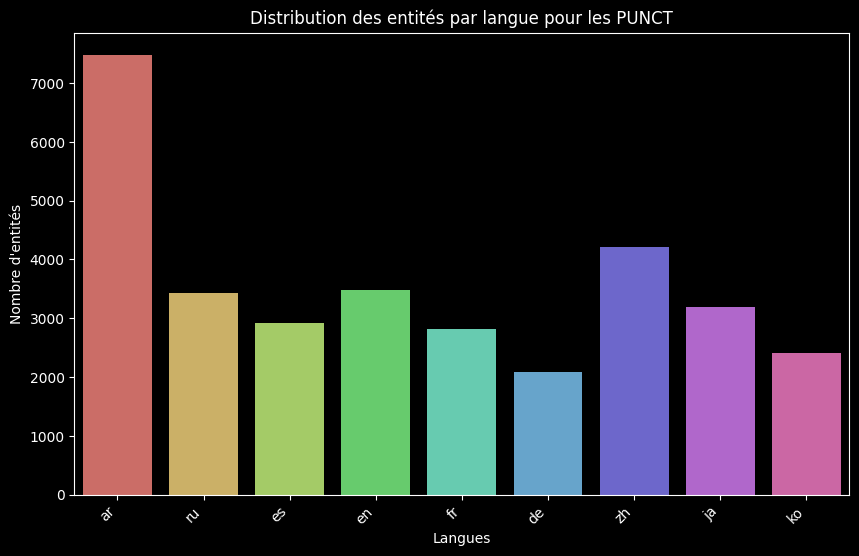

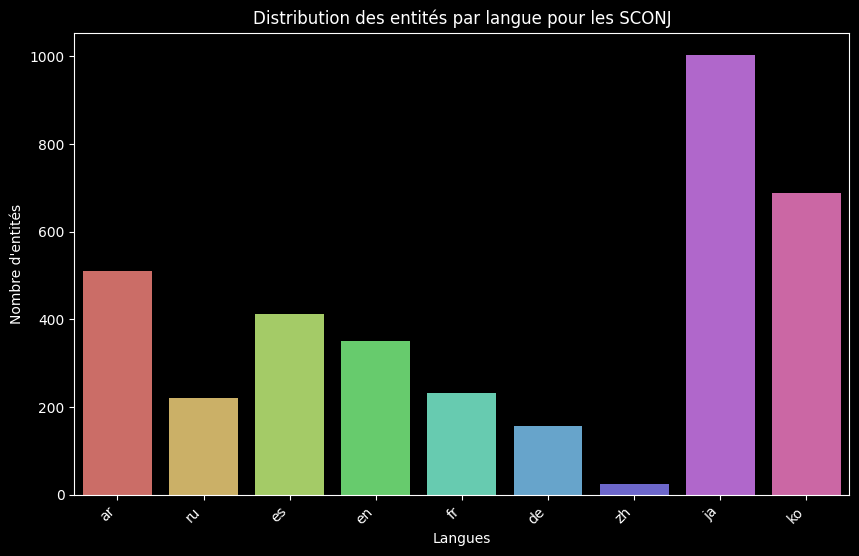

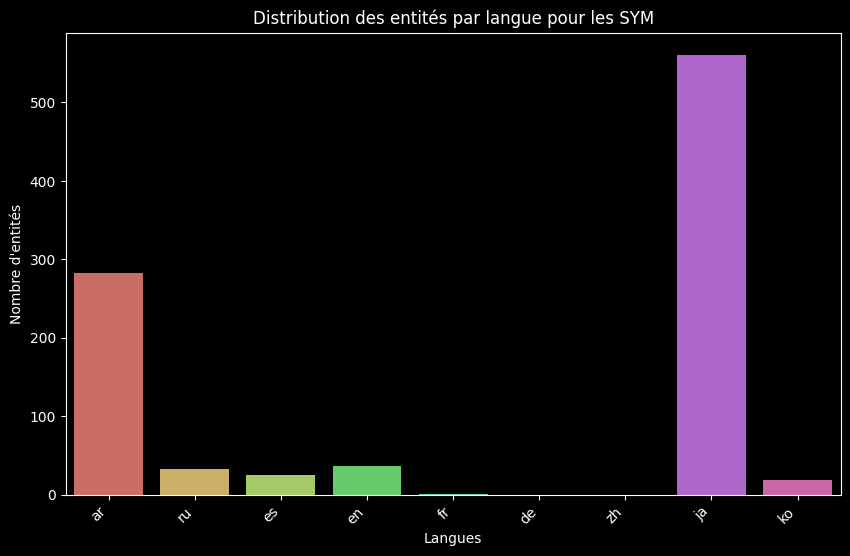

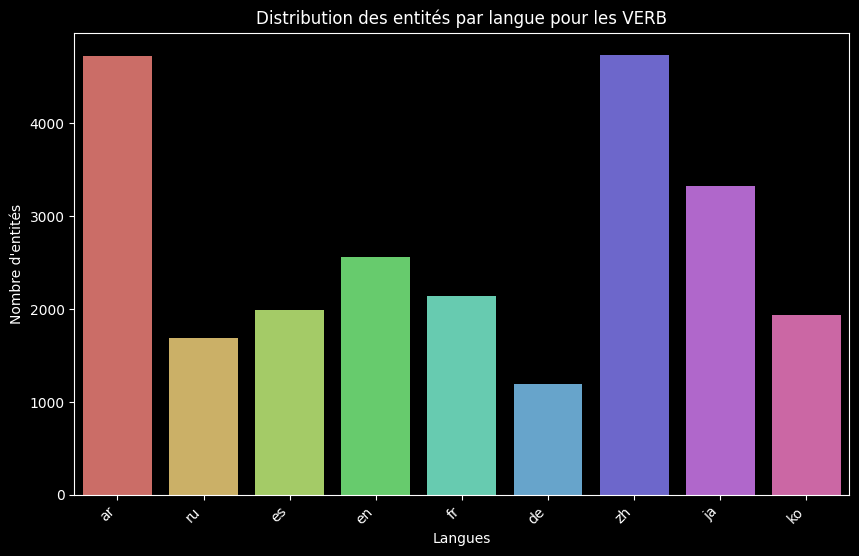

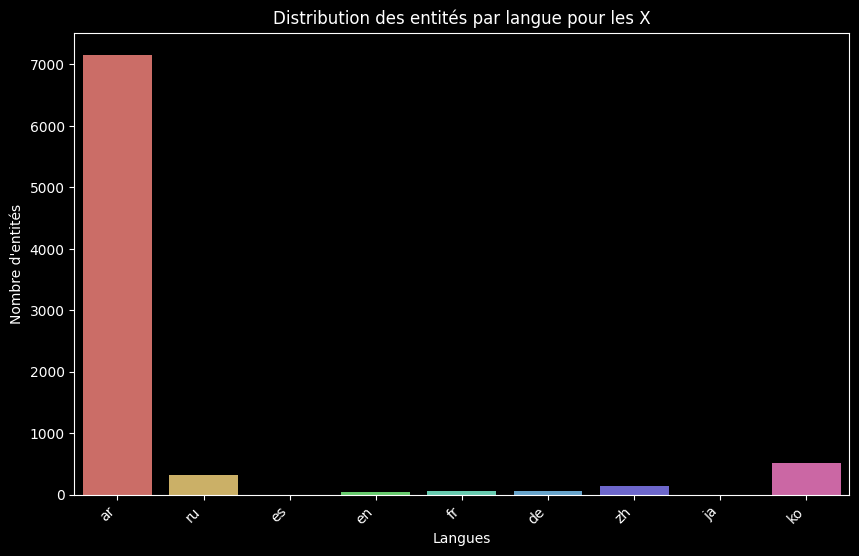

In [7]:
def plot_entity_distribution_per_POS(data: pd.DataFrame, output_directory: str):
    """
    Trace un graphique en barres pour chaque langue montrant la distribution des entités par type.

    Parameters:
    data (pd.DataFrame): DataFrame des entités retourné par la fonction count_entities.
    output_directory (str): Répertoire dans lequel enregistrer les graphiques.
    """
    # Tracé des graphiques séparés pour chaque langue
    for pos in data["Unnamed: 0"].unique():
        # Filtrer les données pour la langue spécifique
        data_pos = data[data["Unnamed: 0"] == pos]

        # Convertir le DataFrame en format long
        data_pos_long = data_pos.melt(
            id_vars=["Unnamed: 0"], var_name="Langues", value_name="Count"
        )

        # Renommer les colonnes pour correspondre à ce que la fonction plot_entity_distribution_per_language attend
        data_pos_long.rename(columns={"Unnamed: 0": "POS"}, inplace=True)

        # Création d'une palette de couleurs personnalisée basée sur le nombre de types d'entités
        num_entity_types = len(data_pos_long["Langues"].unique())

        # Tracé avec Matplolib en utilisant la palette personnalisée
        plt.figure(figsize=(10, 6))
        sns.barplot(
            x="Langues",
            y="Count",
            hue="Langues",
            data=data_pos_long,
            palette="hls",
            dodge=False,
            legend=False,
        )
        plt.xticks(rotation=45, ha="right")
        plt.xlabel("Langues")
        plt.ylabel("Nombre d'entités")
        plt.title(f"Distribution des entités par langue pour les {pos}")

        # Enregistrement du graphique
        plt.savefig(
            f"{output_directory}/{pos}_distribution.png",
            facecolor="w",
            bbox_inches="tight",
        )

        plt.show()
        plt.close()


# Utilisation de la fonction
data = pd.read_csv("../../resultats/entities.csv")
plot_entity_distribution_per_POS(data, "../../resultats/POS_distribution")

1. **Boucle à travers les types de parties du discours (POS)** :
   - La fonction parcourt chaque type de partie du discours (POS) listé dans la colonne `Unnamed: 0` du DataFrame. Pour chaque type de POS, un sous-ensemble de données est extrait pour une analyse plus détaillée.

2. **Préparation des données** :
   - Les données sont filtrées pour isoler les occurrences de chaque type de POS spécifique. Ensuite, elles sont converties en format long, facilitant ainsi la manipulation des données pour le tracé graphique. Cette transformation arrange les données de manière à ce que chaque ligne contienne une combinaison unique de langue et de comptage d'entités pour un type de POS donné.

3. **Renommer les colonnes** :
   - La colonne initialement nommée `Unnamed: 0`, qui contient les types de POS, est renommée en `POS` pour une meilleure clarté lors des étapes suivantes de manipulation et de visualisation des données.

4. **Tracer le graphique** :
   - Un graphique en barres est généré pour chaque type de POS en utilisant Matplotlib et Seaborn. Les langues sont affichées sur l'axe des x et les nombres d'entités sur l'axe des y. Une palette de couleurs est appliquée pour distinguer visuellement les données de différentes langues sur le graphique.

5. **Enregistrer le graphique** :
   - Chaque graphique est sauvegardé dans un répertoire spécifié, en utilisant un format qui inclut le type de POS dans le nom du fichier pour faciliter l'identification et l'accès ultérieur.

6. **Utilisation de la fonction** :
   - La fonction est appelée avec un DataFrame contenant les données d'entités et un chemin vers un répertoire où les graphiques seront enregistrés. Cela permet d'exécuter la fonction dans un contexte pratique où les résultats sont facilement organisés et accessibles.

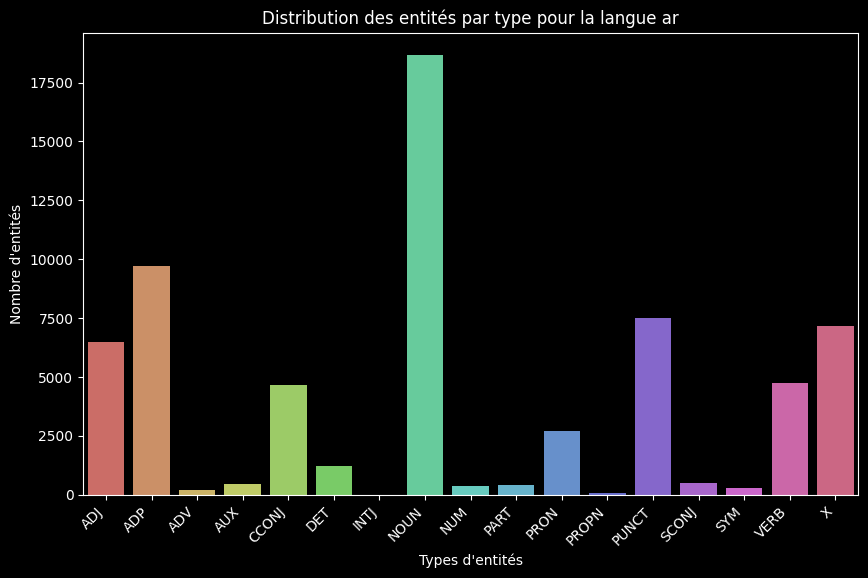

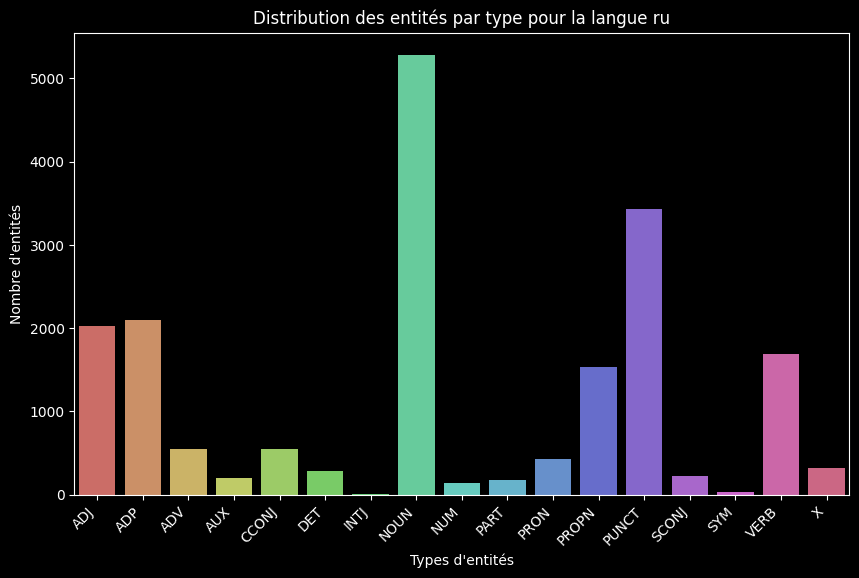

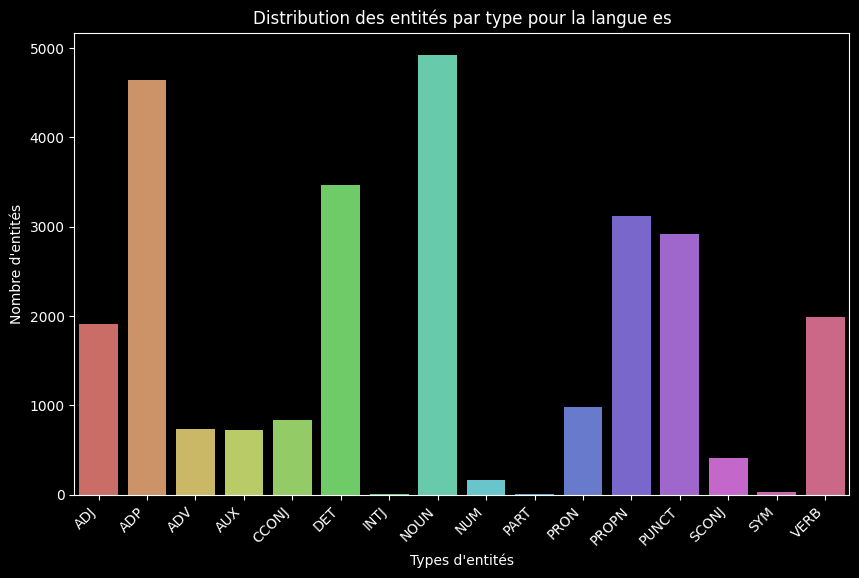

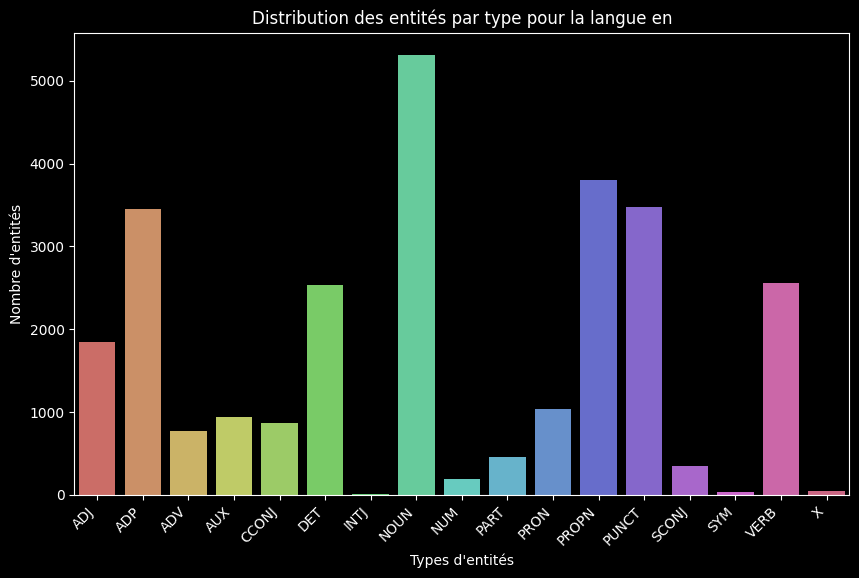

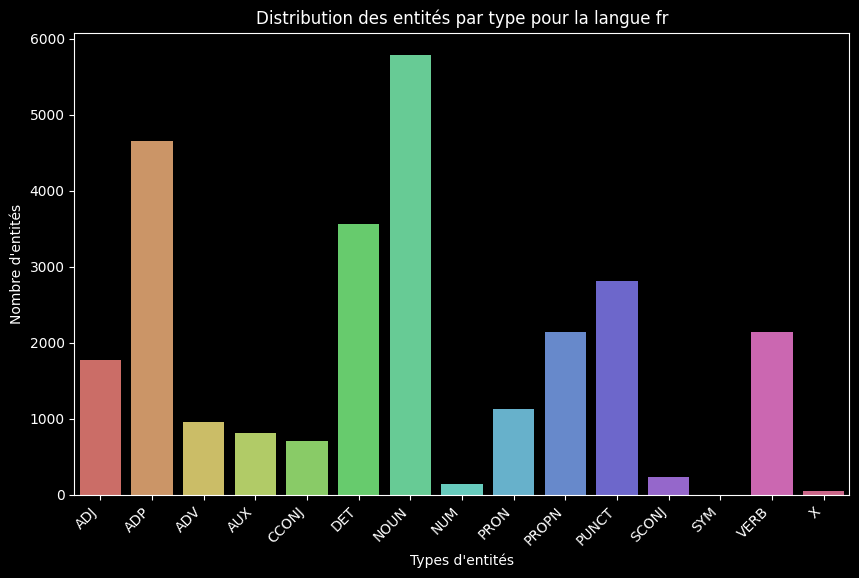

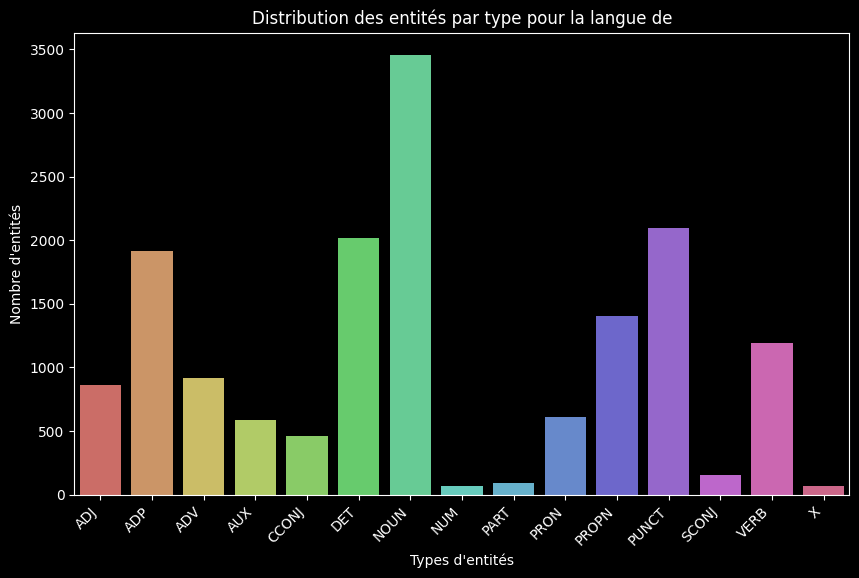

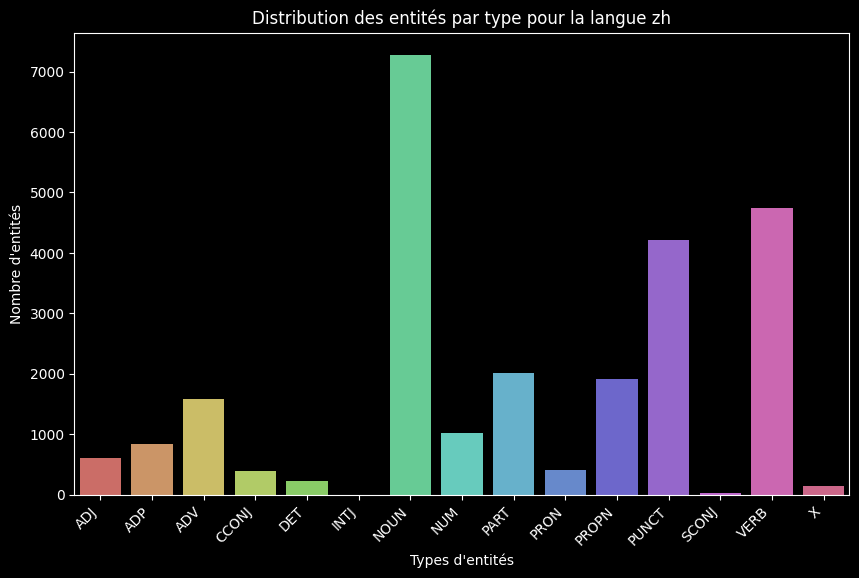

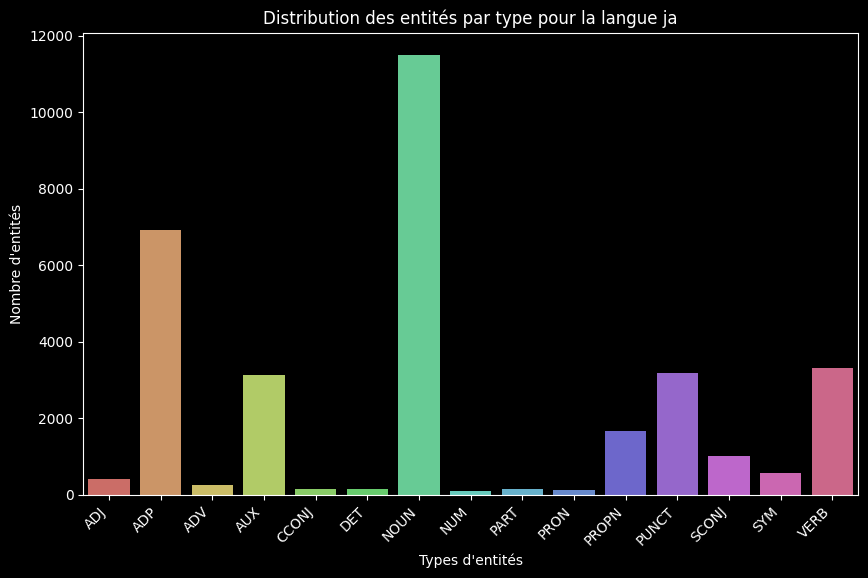

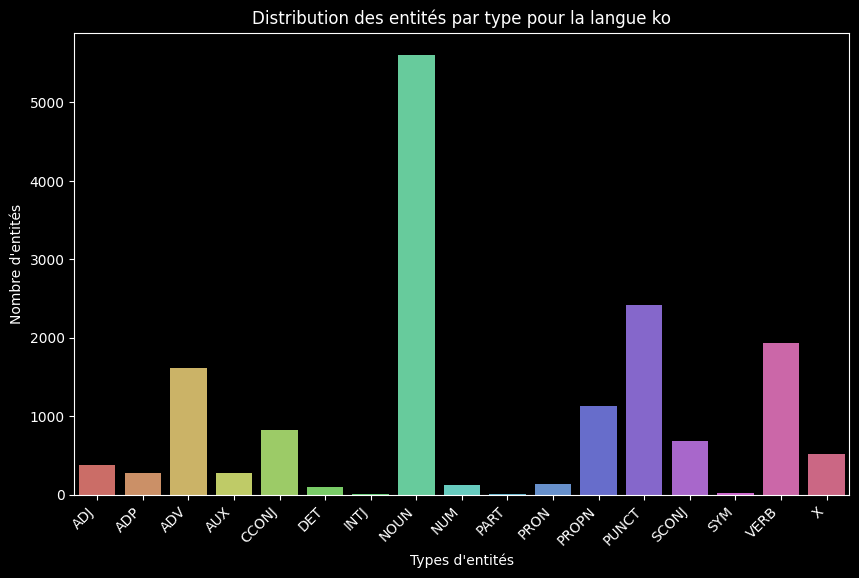

In [8]:
def tracer_distribution_par_langue(data: pd.DataFrame, repertoire_sortie: str) -> None:
    """
    Trace un graphique en barres pour chaque langue montrant la distribution des étiquettes grammaticales.

    Paramètres :
        data (pd.DataFrame) : DataFrame contenant les entités, avec les colonnes correspondant aux langues.
        repertoire_sortie (str) : Répertoire dans lequel enregistrer les graphiques.
    """
    # Vérifier que le répertoire de sortie existe
    os.makedirs(repertoire_sortie, exist_ok=True)

    # Tracer des graphiques distincts pour chaque langue
    for langue in data.columns[1:]:  # Sauter la première colonne, qui est 'Unnamed: 0'
        # Filtrer les données pour la langue spécifique
        data_langue = data[["Unnamed: 0", langue]].dropna()
        data_langue.columns = [
            "POS",
            "Nombre d'entités",
        ]  # Renommer les colonnes pour le tracé

        # Tracer en utilisant Seaborn avec une palette de couleurs
        plt.figure(figsize=(10, 6))
        sns.barplot(
            x="POS",
            y="Nombre d'entités",
            hue="POS",
            data=data_langue,
            palette="hls",
            dodge=False,
            legend=False,
        )
        plt.xticks(rotation=45, ha="right")
        plt.xlabel("Types d'entités")
        plt.ylabel("Nombre d'entités")
        plt.title(f"Distribution des entités par type pour la langue {langue}")

        # Enregistrer le graphique
        plt.savefig(
            f"{repertoire_sortie}/{langue}_distribution.png",
            facecolor="w",
            bbox_inches="tight",
        )
        plt.show()
        plt.close()


# Utilisation de la fonction
tracer_distribution_par_langue(data, "../../resultats/langue_distribution")